# Deep learning: mausy or slimsy

This project aims to train a deep learning model to do classification. A learned model is good if by taking input of jpg files of mausy and slimsy, it can correctly predict if the object in the file is mausy or slimsy to a high probability.

# Structure:
- Section 1. check if internet is connected
- Section 2. update libraries such as fastai, duckduckgo_search
- Section 3.load input images into data blocks
- Section 4.train a model taking input data
- Section 5.predict with the model on unused data

## Section 1. check if internet is connected

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

## Section 2. update libraries such as fastai, duckduckgo_search and import them

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

In [3]:
from duckduckgo_search import DDGS 
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Testing: duckduckgo_search
Below code block defines a search image function that returns image(images) based on term of your interest.

Searching for 'dog modern'...


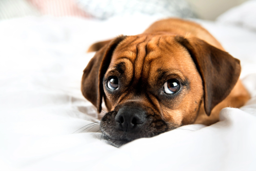

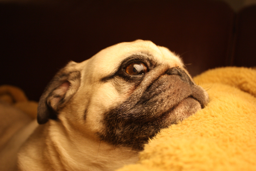

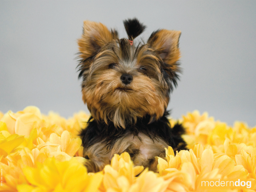

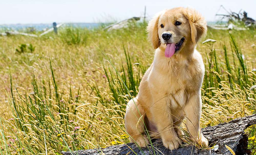

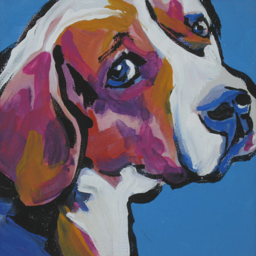

In [4]:
def search_images(term,max_images = 30):
    print(f"Searching for '{term}'...")
    return L(DDGS().images(term,max_results = max_images)).itemgot("image")

testing_term = "dog modern"

urls = search_images(testing_term, max_images=5)

for i in range(len(urls)):
    testing_dest = f'{testing_term}_{i}.jpg'
    #print(testing_dest,urls[i])
    try:
        download_url(urls[i], testing_dest, show_progress=False)
        img = Image.open(testing_dest).to_thumb(256,256)
        display(img)
    except:
        #print("failed")
        continue


## Section 3: load input images into data blocks

In [5]:
### Testing data blocks with online images from duckduckgo_search

In [6]:
searches = 'pig stuffed animal','panda stuffed animal'
path = Path('animal_classifier')
from time import sleep


for o in searches:
    dest = (path/o)
    print(dest)
    dest.mkdir(exist_ok = True, parents = True)
    download_images(dest, urls = search_images(f"{o} pictures"))
    sleep(10)
    download_images(dest, urls = search_images(f"{o} modern"))
    sleep(10)
    resize_image(path/o, max_size = 400, dest = path/o)
            



animal_classifier/pig stuffed animal
Searching for 'pig stuffed animal pictures'...
Searching for 'pig stuffed animal modern'...
animal_classifier/panda stuffed animal
Searching for 'panda stuffed animal pictures'...
Searching for 'panda stuffed animal modern'...


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

In [8]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.1,seed = 32),
    get_y = parent_label,
    item_tfms = [Resize(192,method = 'squish')]
).dataloaders(path,bs=32)

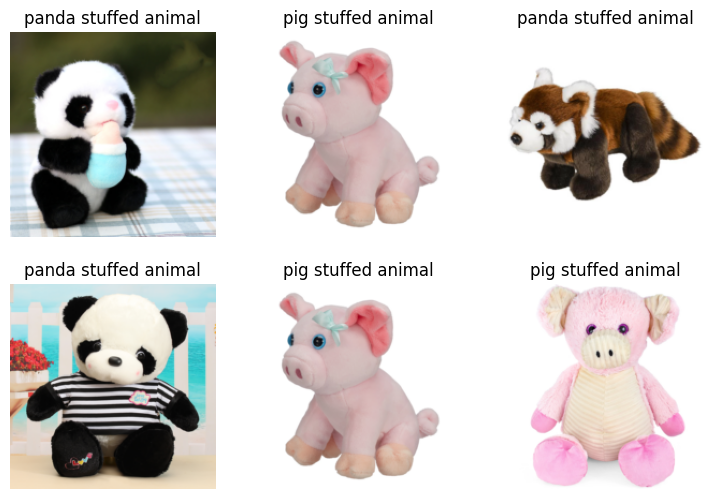

In [9]:
dls.show_batch(max_n = 6)

In [10]:
pwd

'/kaggle/working'

### Now load real data

Know which repo the code is curretly in. The input data is in input folder instead of working folder


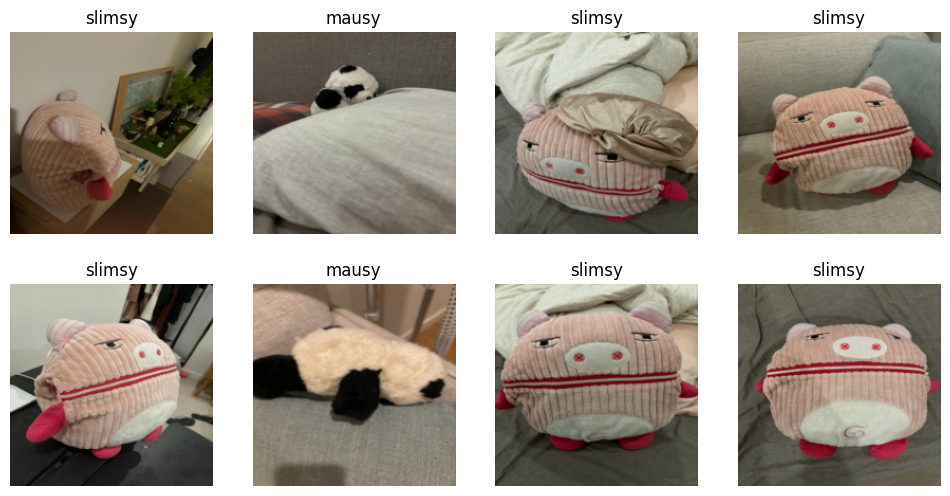

In [11]:
path_new = Path('../input/mausy-and-slimsy/mausy-and-slimsy')
dls_new = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2,seed = 42),
    get_y = parent_label,
    item_tfms = [Resize(192,method = 'squish')]
).dataloaders(path_new,bs=32)

dls_new.show_batch(max_n = 8)


## Learning time

In [12]:
learner = vision_learner(dls_new, resnet152, metrics = error_rate)
learner.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 181MB/s]


## Section 4.5 Data Cleaning after training

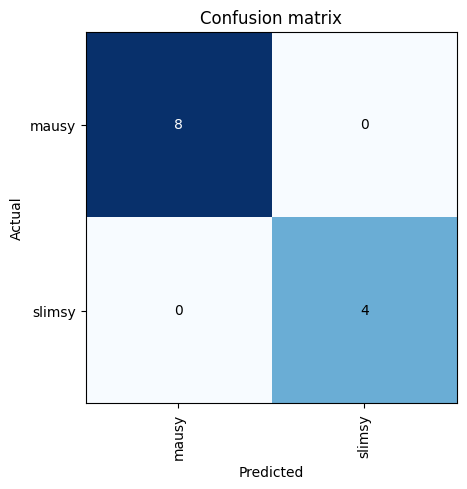

In [13]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

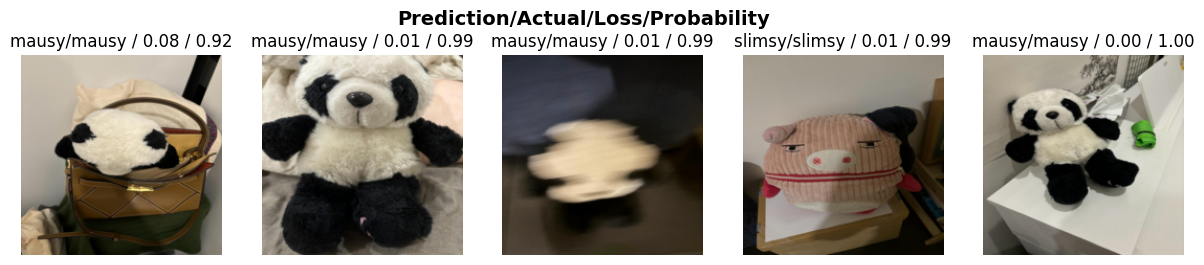

In [14]:
interp.plot_top_losses(5, nrows=1)

In [15]:
#hide_output
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learner)
cleaner

In [16]:
print(cleaner.change())

[]


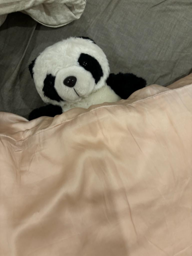

In [17]:
to_be_changed = Image.open(cleaner.fns[0]).to_thumb(256,256)
to_be_changed

In [18]:
#below is to delete images that we don't want to keep
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#below is to modify the category
for idx,category in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/category)

### Note:
The above line is gonna give you error if you try to change/delete: [Errno 30] Read-only file system: '../input/mausy-and-slimsy/mausy-and-slimsy/mausy/PHOTO-2024-01-02-05-17-43 5.jpg'
this is because your data is stored from kaggle instead of only on your os. 
It's a read-only file.

## Time to retrain

I will omit it here.

## Section 5: predict with the model on unused data

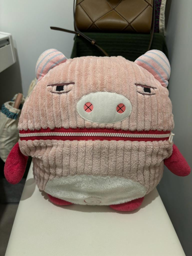

This is a: slimsy with probability 0.9982465505599976.


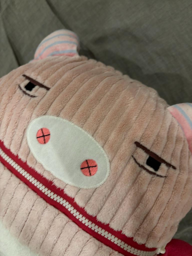

This is a: slimsy with probability 0.9999892711639404.


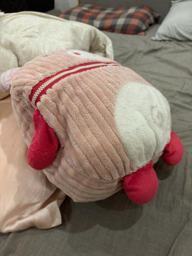

This is a: slimsy with probability 0.9995878338813782.


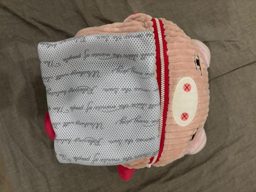

This is a: slimsy with probability 0.9999390840530396.


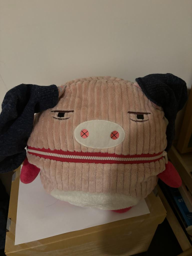

This is a: slimsy with probability 0.9915511608123779.


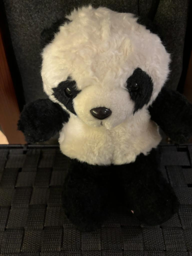

This is a: mausy with probability 0.999984860420227.


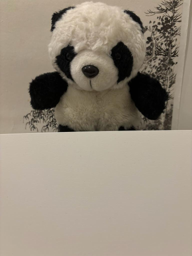

This is a: mausy with probability 0.9999579191207886.


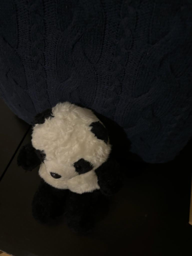

This is a: mausy with probability 0.7733708024024963.


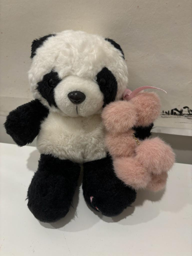

This is a: mausy with probability 0.9986808896064758.


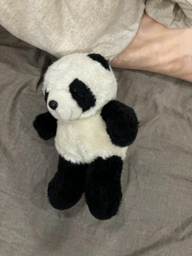

This is a: mausy with probability 0.9995827078819275.


In [19]:
test_path = Path('../input/mausy-and-slimsy/testing-mausy-and-slimsy')
#print(test_path)
for p in get_image_files(test_path):
    img = Image.open(p).to_thumb(256,256)
    display(img)
    tech_gadget_classify,category,probs = learner.predict(PILImage.create(img))
    print(f"This is a: {tech_gadget_classify} with probability {probs[category]}.")
    
            


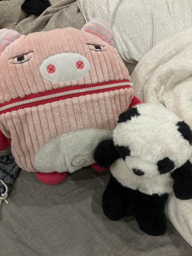

This is a: slimsy with probability 0.9287396669387817.


In [20]:
test_path = Path('../input/mausy-and-slimsy/difficult')
#print(test_path)
for p in get_image_files(test_path):
    img = Image.open(p).to_thumb(256,256)
    display(img)
    tech_gadget_classify,category,probs = learner.predict(PILImage.create(img))
    print(f"This is a: {tech_gadget_classify} with probability {probs[category]}.")

In [21]:
print(learner)

_______________


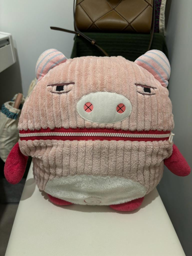

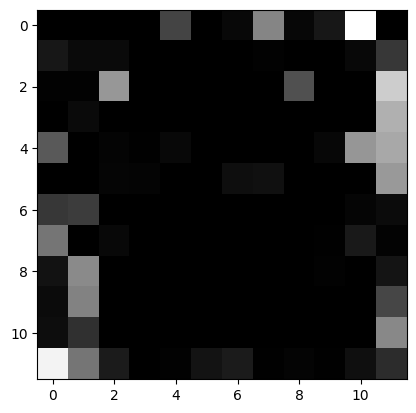

This is a: slimsy with probability 0.9982465505599976.
_______________


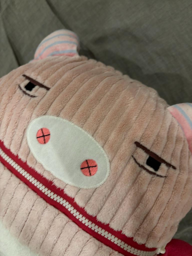

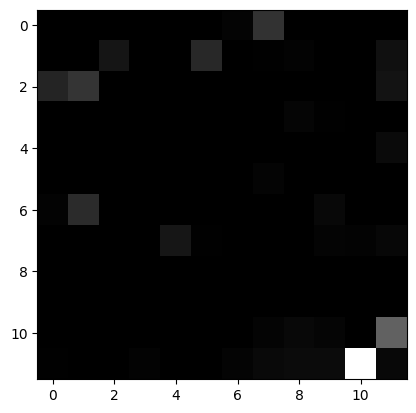

This is a: slimsy with probability 0.9999892711639404.
_______________


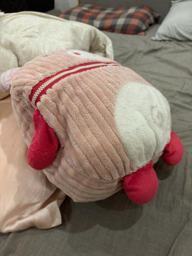

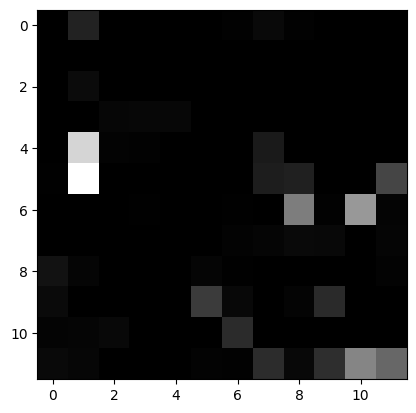

This is a: slimsy with probability 0.9995878338813782.
_______________


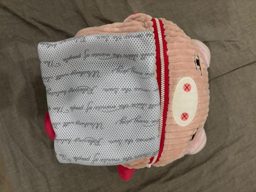

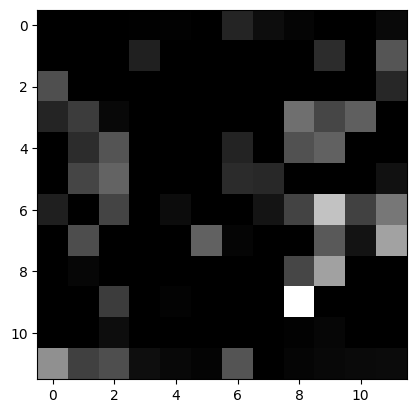

This is a: slimsy with probability 0.9999390840530396.
_______________


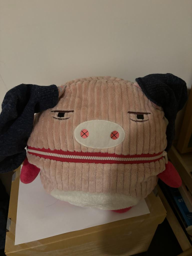

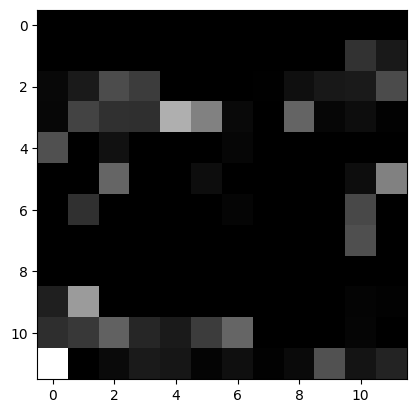

This is a: slimsy with probability 0.9915511608123779.
_______________


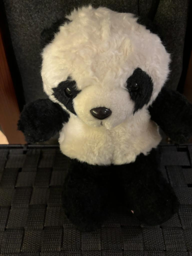

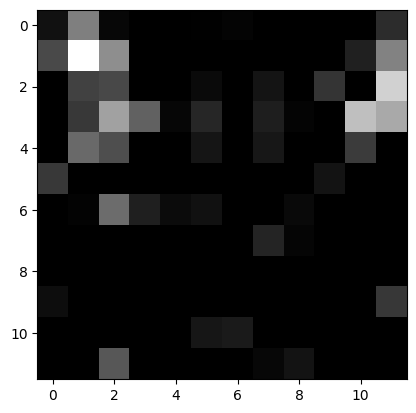

This is a: mausy with probability 0.999984860420227.
_______________


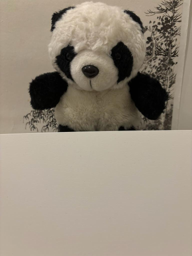

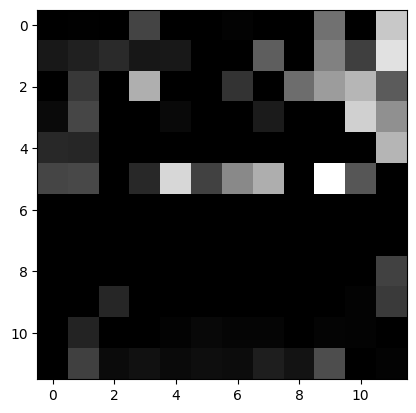

This is a: mausy with probability 0.9999579191207886.
_______________


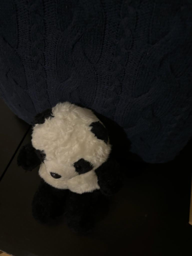

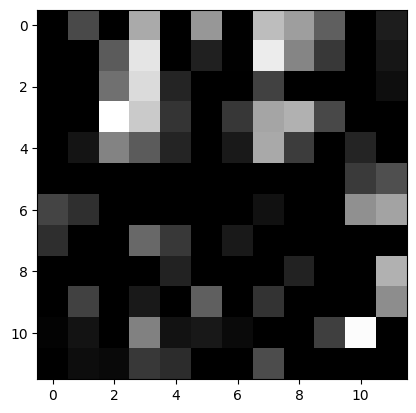

This is a: mausy with probability 0.7733708024024963.
_______________


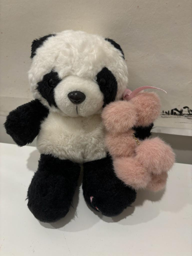

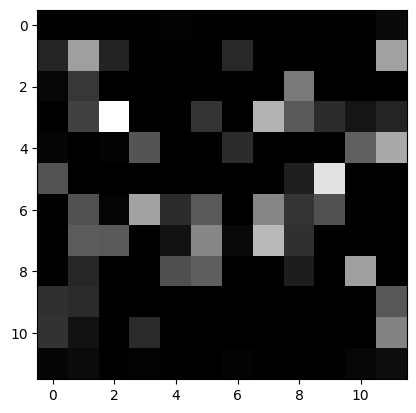

This is a: mausy with probability 0.9986808896064758.
_______________


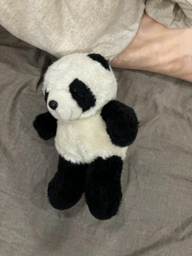

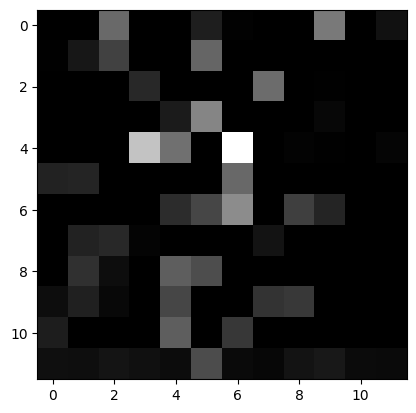

This is a: mausy with probability 0.9995827078819275.


In [22]:
import matplotlib.pyplot as plt
def hook_fn(m, i, o):
    activations.append(o)

test_path = Path('../input/mausy-and-slimsy/testing-mausy-and-slimsy')
#print(test_path)
for p in get_image_files(test_path):
    print(f"_"*15)
    your_image = Image.open(p).to_thumb(256,256)
    display(your_image)
    # Function to store the activations
    activations = []
    hook = learner.model[0][6][1].register_forward_hook(hook_fn)
    tech_gadget_classify,category,probs = learner.predict(PILImage.create(your_image))
    # Remove the hook
    hook.remove()

# Visualize the activations
    
    plt.imshow(activations[0][0].detach().cpu().numpy()[0], cmap='gray')
    plt.show()
    print(f"This is a: {tech_gadget_classify} with probability {probs[category]}.")







## Export your model
Check your dir, if you see nothing on your right side of screen, refresh the browser

In [23]:
learner.export()

In [24]:
ls

 __notebook__.ipynb  'dog modern_0.jpg'  'dog modern_2.jpg'  'dog modern_4.jpg'
 animal_classifier/  'dog modern_1.jpg'  'dog modern_3.jpg'   export.pkl
